h= 1.0 

0.00013070607192495773
0.00013070607192495773


h= 0.5 

8.564193902045417e-06
8.564193902045417e-06


h= 0.25 

5.428544673973326e-07
5.428544673973326e-07


h= 0.125 

3.4054428068109356e-08
3.4054428068109356e-08


h= 0.0625 

2.130401555965165e-09
2.130401555965165e-09




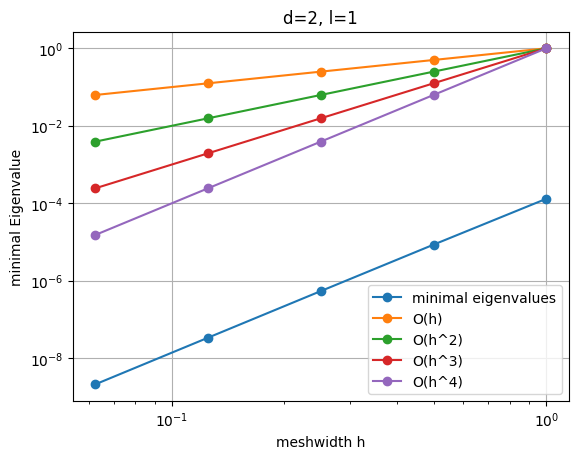

In [1]:
from ngsolve import *
from ngsolve.webgui import Draw
from netgen.occ import *
import matplotlib.pyplot as plt
import numpy as np
import scipy as sp

meshwidths = np.array([1.0,0.5,0.25,0.125,0.0625]) 
minEV = np.zeros(len(meshwidths))

k = 0

netgen_mesh =unit_square.GenerateMesh(maxh=1)
mesh=Mesh(netgen_mesh)

for h in meshwidths:
    print("h=",h, "\n")
    #Draw(mesh)

    #set function space, for l=0 its normal lagrangian finite elements
    #need to compress to remove DOFs of unrefined mesh after refinement
    H_h = Compress(HDiv(mesh, order = 1, RT=True)) # main function space
    H_H = Compress(HDiv(mesh, order = 2, RT=True)) # high order Function space for Riesz representative  
    
    #choose w_h and set its values on the nodes
    # w = CoefficientFunction((sin(x),cos(y)))
    # w_h = GridFunction(H_h) #set the nodes
    # w_h.Set(w)

    # f_H = GridFunction(H_H, name="f_H") #high order 


    #low order
    u_h = H_h.TrialFunction() # define the trial function
    v_h = H_h.TestFunction() # define the test function
    #High order
    u_H = H_H.TrialFunction() # define the trial function
    v_H= H_H.TestFunction() # define the test function

    m = BilinearForm(H_H) #define m with the L2 inner product on the high order space
    m += u_H*v_H * dx 
    m.Assemble()

    a = BilinearForm(H_H) # define the Hdiv inner product on the high order space
    a += div(u_H) * div(v_H) * dx
    a += u_H*v_H * dx 
    a.Assemble()


    #embedding matrix t
    a_mixed = BilinearForm(trialspace=H_h, testspace=H_H)
    a_mixed += u_h*v_H*dx
    a_mixed.Assemble()

    a_dest = BilinearForm(H_H)
    a_dest += u_H*v_H*dx
    a_dest.Assemble()

    t = a_dest.mat.Inverse() @ a_mixed.mat

    #w_H is the high order embedding of w_h
    # w_H = GridFunction(H_H, name="w_H")
    # w_H.vec.data = t * w_h.vec

    #compute riesz representative
    a_inv = a.mat.Inverse(freedofs=H_H.FreeDofs())

    #solve for the riesz representative (f_H) 
    # temp = f_H.vec.CreateVector()
    # temp.data = m.mat * w_H.vec
    # f_H.vec.data = a_inv * temp

    #create Matrices for GEV problem

    #c is the low order galerkin matrix
    c = BilinearForm(H_h)
    c += div(u_h) * div(v_h) * dx
    c += u_h*v_h * dx 
    c.Assemble()

    #check norms
    # temp3 = c.mat * w_h.vec
    # w_h_norm = w_h.vec.InnerProduct(temp3)
    # print("H(div) norm of w_h:", sqrt(w_h_norm)) #norm of w_h in H(div,

    # temp4 = a.mat * f_H.vec
    # f_H_norm = f_H.vec.InnerProduct(temp4)
    # print("H(div) norm of f_H, the riesz representative of w_h:", sqrt(f_H_norm)) #norm of the riesz representative

    #b = t.T @ m.mat.T @ a_inv @ m.mat @ t

    C = c.mat.ToDense().NumPy()
    M = m.mat.ToDense().NumPy()
    A_inv = a_inv.ToDense().NumPy()
    T = t.ToDense().NumPy()

    #M == M.T 
    B = T.T @ M.T @ A_inv @ M @ T

    EV = sp.linalg.eigvalsh(B,C)
    lam=min(EV)
    print(lam)
    lam_abs = np.abs(lam)
    print(lam_abs)
    minEV[k] = lam_abs

    k = k + 1
    mesh.Refine()
    print("\n")

fig, ax = plt.subplots()
plt.grid(visible=True)
plt.loglog(meshwidths,minEV, 'o-', label="minimal eigenvalues")
plt.loglog(meshwidths,meshwidths,'o-', label="O(h)")
plt.loglog(meshwidths,np.power(meshwidths,2),'o-', label="O(h^2)")
plt.loglog(meshwidths,np.power(meshwidths,3),'o-', label="O(h^3)")
plt.loglog(meshwidths,np.power(meshwidths,4),'o-', label="O(h^4)")
plt.xlabel('meshwidth h')
plt.ylabel('minimal Eigenvalue')
plt.title('d=2, l=1')
plt.legend()
plt.show()
